# --- TinyML Preprocessing & Baseline Model ---
# Author: Victor Lopez

## Environment verification

In [5]:
import sys, platform
import pandas as pd, sklearn 
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("Pandas:", pd.__version__, " scikit-learn:", sklearn.__version__)

try:
    import tensorflow as tf
    print("tensorflow:", tf.__version__)
except Exception as e:
    print("tensorflow: not installed:", e)

Python: 3.11.14
Platform: macOS-15.7.1-arm64-arm-64bit
Pandas: 2.3.3  scikit-learn: 1.7.2
tensorflow: 2.16.2


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [7]:
from pathlib import Path
print ("CWD:", Path.cwd())

CWD: /Users/victorlopez/EdgeAI-SmartIrrigationSystem


In [8]:
df = pd.read_csv('firmware/data/dataset_clean.csv')
print("Original columns:", list(df.columns))
rename_map = {
    "field1": "soil1",
    "field2": "soil2",
    "field3": "temp_c",
    "field4": "humidity",
    "field5": "light",
    "field6": "decision",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
print("Renamed columns:", list(df.columns))

wanted = ['soil1', 'soil2', 'temp_c', 'humidity', 'light', 'decision']
available = [c for c in wanted if c in df.columns]
df = df[available]
print("Final columns used:", list(df.columns))

Original columns: ['created_at', 'entry_id', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'latitude', 'longitude', 'elevation', 'status']
Renamed columns: ['created_at', 'entry_id', 'soil1', 'soil2', 'temp_c', 'humidity', 'light', 'decision', 'latitude', 'longitude', 'elevation', 'status']
Final columns used: ['soil1', 'soil2', 'temp_c', 'humidity', 'light', 'decision']


In [9]:
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna()

In [10]:
if "decision" not in df.columns and {'soil1', 'soil2'}.issubset(df.columns):
    df['decision'] = ((df['soil1'] > 600) | (df['soil2'] > 600)).astype(int)

In [11]:
wanted = ['soil1', 'soil2', 'temp_c', 'humidity', 'light', 'decision']
missing = [c for c in wanted if c not in df.columns]

In [12]:
print("Columns in DF:", list(df.columns))
print("Missing (should be empty):", missing)
print("Shape:", df.shape)

# Small sanity check: label balance
print("\nLabel balance:")
print((df['decision'].value_counts(normalize=True)*100).round(1).astype(str) + '%')

Columns in DF: ['soil1', 'soil2', 'temp_c', 'humidity', 'light', 'decision']
Missing (should be empty): []
Shape: (5689, 6)

Label balance:
decision
1    73.0%
0    27.0%
Name: proportion, dtype: object


# Normalization + split + baseline

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [14]:
X = df[["soil1", "soil2", "temp_c", "humidity", "light"]].values
y = df["decision"].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)




Train: (4551, 5) Test: (1138, 5)


# Baseline TinyML model: Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc*100:.2f}%\n")
print("Classification report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 100.00%

Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       307
           1      1.000     1.000     1.000       831

    accuracy                          1.000      1138
   macro avg      1.000     1.000     1.000      1138
weighted avg      1.000     1.000     1.000      1138

Confusion matrix:
 [[307   0]
 [  0 831]]


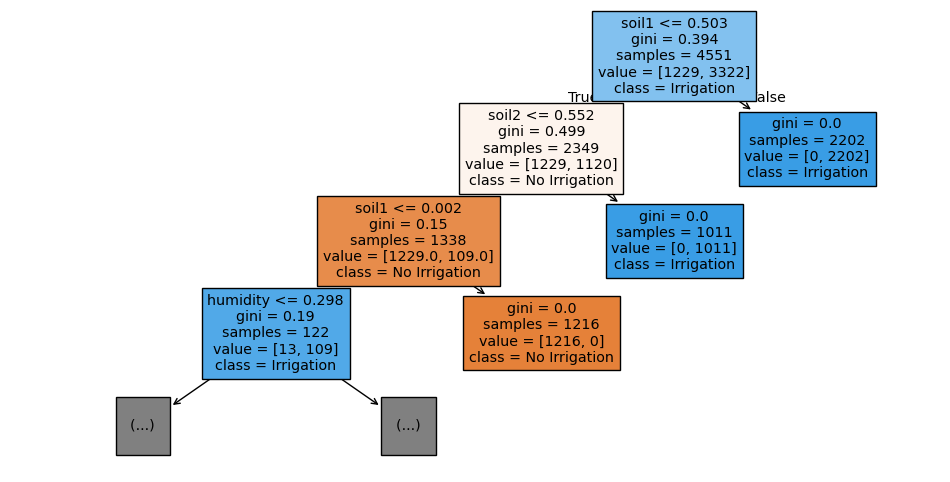

In [16]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
tree.plot_tree(clf, 
               feature_names=["soil1", "soil2", "temp_c", "humidity", "light"], class_names=["No Irrigation", "Irrigation"],
               filled=True, max_depth=3)
plt.show()

In [17]:
# Save trained model and scaler for later conversion to TensorFlow Lite

from pathlib import Path
import joblib
import json
from datetime import datetime, timezone

models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(clf, models_dir / "baseline_decision_tree.joblib")
joblib.dump(scaler, models_dir / "minmax_scaler.joblib")

# Save metadata
meta = {
    "created_at": datetime.now(timezone.utc).isoformat(),
    "model": "DecisionTreeClassifier",
    "max_depth": 5,
    "features": ["soil1", "soil2", "temp_c", "humidity", "light"],
    "label": "decision",
    "train_size": int(X_train.shape[0]),
    "test_size": int(X_test.shape[0]),
    "accuracy_test": float(acc),
}
with open(models_dir / "model_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved:",
        (models_dir / "baseline_decision_tree.joblib").resolve(),
        (models_dir / "minmax_scaler.joblib").resolve(),
        (models_dir / "model_metadata.json").resolve(),
        sep="\n "
    )

Saved:
 /Users/victorlopez/models/baseline_decision_tree.joblib
 /Users/victorlopez/models/minmax_scaler.joblib
 /Users/victorlopez/models/model_metadata.json


In [19]:
# --- TinyML baseline in Keras ---

from tabnanny import verbose
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# 1) Ensure required columns exist
feature_cols = ["soil1", "soil2", "temp_c", "humidity", "light"]
assert all(c in df.columns for c in feature_cols), f"Missing features in df: {feature_cols}"

# If the dataset lacks the target 'decision', derive it with the same rule used to synthesize labels
if "decision" not in df.columns:
    df['decision'] = ((df['soil1'] > 600) | (df['soil2'] > 600)).astype(int)

# 2) Split features/labels
X = df[feature_cols].to_numpy(dtype=np.float32)
y = df['decision'].to_numpy(dtype=np.float32)

# 3) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)  
print("Train/Test shapes:", X_train.shape, X_test.shape)

# 4) Feature scaling (Min-Max [0,1]
model = keras.Sequential([
    keras.layers.Input(shape=(len(feature_cols),)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping to avoid overfitting
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

# 6) Evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Quick sanity prediction (first 3 samples)
probs = model.predict(X_test[:3], verbose=0).ravel()
preds = (probs >= 0.5).astype(int)
print("Sample probs:", np.round(probs, 3), "preds:", preds, "true:", y_test[:3].astype(int))


Train/Test shapes: (4551, 5) (1138, 5)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4887 - loss: 143.5085 - val_accuracy: 0.6872 - val_loss: 22.9821
Epoch 2/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6934 - loss: 19.9717 - val_accuracy: 0.6729 - val_loss: 16.3202
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6931 - loss: 12.5934 - val_accuracy: 0.6762 - val_loss: 8.2633
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6462 - loss: 4.0606 - val_accuracy: 0.7278 - val_loss: 1.8130
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6253 - loss: 1.0465 - val_accuracy: 0.7278 - val_loss: 1.2273
Epoch 6/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6780 - loss: 0.7331 - val_accuracy: 0.7278 - val_loss: 1.0015
Epoch 7/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7080 - loss: 0.6311 - val_accuracy: 0.7278 - val_loss: 0.9125
Epoch 8/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7343 - loss: 0.5862 - val_accu

In [20]:
# --- Fix labels and retrain model ---

import numpy as np
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import pandas as pd

feature_cols = ["soil1", "soil2", "temp_c", "humidity", "light"]

# 1) Enforce numeric types and drop NaNs in features
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=feature_cols.copy())

# 2) Recompute label from the original rule
df['decision'] = ((df['soil1'] > 600) | (df['soil2'] > 600)).astype(int)

# 3) Quick check of class balance and baseline
balance = df['decision'].value_counts(normalize=True).sort_index()
print("Label balance:", (balance*100).round(1).astype(str) + '%')
majority_baseline = max(balance[0], balance[1])
print(f"Majority class baseline: {majority_baseline*100:.2f}%")

# 4) Split + scale
X = df[feature_cols].to_numpy(dtype=np.float32)
y = df['decision'].to_numpy(dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5) Slightly bigger tiny model
model = keras.Sequential([
    keras.layers.Input(shape=(5,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    callbacks=[es],
    verbose=0,
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {acc*100:.2f}%")

Label balance: decision
0    29.4%
1    70.6%
Name: proportion, dtype: object
Majority class baseline: 70.59%

Test Accuracy: 90.07%


In [21]:
# --- Feature engineering: soil_max(soil1, soil2) + retrain ---

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

# 1) Build engineered feature
df['soil_max'] = df[['soil1', 'soil2']].max(axis=1)

# 2) Features now include soil_max 
feature_cols = ["soil1","soil2","soil_max","temp_c","humidity","light"]

X = df[feature_cols].apply(pd.to_numeric, errors="coerce").dropna().to_numpy(dtype=np.float32)
y = df.loc[df[feature_cols].notna().all(axis=1), "decision"].to_numpy(dtype=np.float32)

# 3) Split + scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4) Small NN model
model = keras.Sequential([
    keras.layers.Input(shape=(len(feature_cols),)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=16, verbose=0, callbacks=[es])

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy (with soil_max): {acc*100:.2f}%")

Test accuracy (with soil_max): 98.24%


In [24]:
from pathlib import Path
print(Path.cwd())

/Users/victorlopez/EdgeAI-SmartIrrigationSystem


In [26]:
# --- Save Keras TinyML model, scaler and metadata ---

from pathlib import Path
from xml.etree.ElementInclude import include
import joblib, json
from datetime import datetime, timezone

models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# 1) Save
joblib.dump(scaler, models_dir / "minmax_scaler_keras.joblib")

# 2) Save Keras model
model.save(models_dir / "baseline_dense.keras", include_optimizer=False)

# 3) Metadata for documetation and reproducibility
meta = {
    "created_at": datetime.now(timezone.utc).isoformat(),
    "framework": "tensorflow.keras",
    "features": ["soil1","soil2","soil_max","temp_c","humidity","light"],
    "label": "decision",
    "train_size": int(X_train.shape[0]),
    "test_size": int(X_test.shape[0]),
    "accuracy_test": float(acc),
    "scaler_file": "minmax_scaler_keras.joblib",
    "model_file": "baseline_dense.keras",
    "notes": "TinyML neural network model for irrigation decision, trained on synthetic dataset"
}
with open(models_dir / "model_metadata_keras.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved:")
print(" ", (models_dir / 'baseline_dense.keras').resolve())
print(" ", (models_dir / 'minmax_scaler_keras.joblib').resolve())
print(" ", (models_dir / 'model_metadata_keras.json').resolve())

Saved:
  /Users/victorlopez/EdgeAI-SmartIrrigationSystem/models/baseline_dense.keras
  /Users/victorlopez/EdgeAI-SmartIrrigationSystem/models/minmax_scaler_keras.joblib
  /Users/victorlopez/EdgeAI-SmartIrrigationSystem/models/model_metadata_keras.json


In [1]:
# --- Convert trained Keras model to TensorFlow Lite format ---
# ---
# NOTE (2025-10-29):
# The following cell caused kernel crashes on macOS due to Metal GPU usage.
# The conversion to TensorFlow Lite was successfully done externally using:
#   python tools/convert_to_tflite.py
# The .tflite file is now located in models/baseline_dense.tflite
# This cell is kept here for documentation purposes only.
# ---

#  (Disabled to avoid crash)

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# import tensorflow as tf
# from pathlib import Path

#  Disable GPU completely for TensorFlow
# try:
#     tf.config.set_visible_devices([], "GPU")
# except Exception:
#     pass

# Limit threading (prevents crashes on M1/M2 macs)
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)

# Convert the trained dense model to TensorFlow Lite
# keras_model_path = Path("models/baseline_dense.keras")
# tflite_path = Path("models/baseline_dense.tflite")

# model = tf.keras.models.load_model(keras_model_path)

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# tflite_model = converter.convert()

# tflite_path.write_bytes(tflite_model)
# print("Saved:", tflite_path.resolve(), f"({tflite_path.stat().st_size/1024:.2f} KB)")
# print("First 12 bytes:", list(tflite_model[:12]))

In [2]:
# --- Generate model_data.h for Arduino ---

from pathlib import Path

tflite_path = Path("models/baseline_dense.tflite")
arduino_dir = Path("firmware/arduino_edge")
arduino_dir.mkdir(parents=True, exist_ok=True)

data = tflite_path.read_bytes()

# Write header file
header_path = arduino_dir / "model_data.h"
with open(header_path, "w") as f:
    f.write("// Auto-generated from baseline_dense.tflite\n")
    f.write("const unsigned char model_tflite[] = {")
    f.write(",".join(str(b) for b in data))
    f.write("};\n")
    f.write(f"const int model_tflite_len = {len(data)};\n")

print("Generated:", header_path.resolve())
print("Model size:", round(len(data)/1024, 2), "KB")

Generated: /Users/victorlopez/EdgeAI-SmartIrrigationSystem/firmware/arduino_edge/model_data.h
Model size: 2.14 KB


In [5]:
# --- Reload saved scaler and extract ranges for Arduino normalization ---

import joblib
import numpy as np
from pathlib import Path

scaler_path = Path("models/minmax_scaler_keras.joblib")

# Reload scaler from disk
scaler = joblib.load(scaler_path)

# Print min and max for hardcoding in Arduino sketch
print("data_min_ =", np.round(scaler.data_min_, 6).tolist())
print("data_max_ =", np.round(scaler.data_max_, 6).tolist())

data_min_ = [450.0, 430.0, 452.0, 18.0, 35.0, 200.0]
data_max_ = [749.0, 739.0, 749.0, 29.899999618530273, 74.9000015258789, 899.0]
